# What does happiness depends on?


\
**CRISP-DM 1. Business Understanding**

In my research I would like to analyse Happiness data from different countries.

Here are 4 questions I would like to answer in my analysis:

1) In which countries should I live to have more chance to be happy?\
2) How Happiness level changes over tree years?\
3) What are the main things that make people happy and how it changed in last 3 years? \
4) How did corona influence happiness of people in 2020?

**CRISP-DM 2. Data Understanding**

To answer these questions I use three datasets of happiness that I found on kaggle webseite. These datasets show happiness scores per country and scores of the variables that may help to explain the score hapiness. They are: GDP per capita, Social support, Healthy life expectancy, Freedom to make life choices, Generosity, Perceptions of corruption. To answer the 4th question about influence of corona on happiness I use one more dataset from kaggle with the latest values of confirmed cases per country.

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

%matplotlib inline

# Here I import the data. This are Happiness data sets for years 2018, 2019, 2020 and last COVID-19 numbers for 2020.
df2018 = pd.read_csv('./Happiness_datasets_748584_1294786_2018.csv')
df2019 = pd.read_csv('./Happiness_datasets_748584_1294786_2019.csv')
df2020 = pd.read_csv('./Happiness_datasets_748584_1294786_2020.csv')
covid = pd.read_csv('./Covid_country_wise_latest.csv')

I look at the datasets separately to check if they have the same structure

In [174]:
# I create a list of Dataframes so that I can process them easily together in a loop in the next steps.
df=[df2018,df2019,df2020,covid]
titles=["Happiness dataset 2018","Happiness dataset 2019","Happiness dataset 2020", "covid dataset"]

for i in range(4):
    print(str(titles[i])+"\n\n"+str(df[i].head()))

Happiness dataset 2018

   Overall rank Country or region  Score  GDP per capita  Social support  \
0             1           Finland  7.632           1.305           1.592   
1             2            Norway  7.594           1.456           1.582   
2             3           Denmark  7.555           1.351           1.590   
3             4           Iceland  7.495           1.343           1.644   
4             5       Switzerland  7.487           1.420           1.549   

   Healthy life expectancy  Freedom to make life choices  Generosity  \
0                    0.874                         0.681       0.202   
1                    0.861                         0.686       0.286   
2                    0.868                         0.683       0.284   
3                    0.914                         0.677       0.353   
4                    0.927                         0.660       0.256   

   Perceptions of corruption  
0                      0.393  
1                      0

**CRISP-DM 3. Prepare Data**

Now I am going to clean the data. First I remove the columns that I dont need for my analysis. I am also going to make the datasets of happiness to have the same structure and the same set of columns to be easier to compare to each other. Moreover I am going to rename columns that have similar values in different datasets, so that they are called the same. I am also going to use Country name as index to access data easily for each country and to leave only quantitative values in my datasets. After that I am going to clean Nan values.

In [175]:
# I see that in the datasets of 2018 and 2019 I have Overall rank, with I dont need
# as it shows the same information as Score. So I remove 'Overall rank' columns:

for i in range(2):
    df[i]=df[i].drop(columns=['Overall rank'])


In [176]:
# I also see that 3 datasets have different names for the same Values, so I make them similar for suitability to use.

df[2].rename(columns = {'Ladder score': 'Score', 'Country name': 'Country', 'Logged GDP per capita':'GDP per capita'}, inplace=True)
df[0].rename(columns = {'Country or region': 'Country'}, inplace=True)
df[1].rename(columns = {'Country or region': 'Country'}, inplace=True)
df[3].rename(columns = {'Country/Region': 'Country'}, inplace=True)


In [177]:
# I saw that 2020 Happiness dataset has more columns than those of 2018 and 2019. So from data of 2020 I choose 
# only columns that also existed in 2018, so that datasets have the same structure and are easier to use together.

df[2]=df[2][df[0].columns]

# I set name of country as an index for all the Happiness datasets, so that I have only quantitative values
# in columns, they are harmonised and I can easily access values for different countries by index.

for i in range(4):
    df[i]=df[i].set_index('Country')


In [178]:
# Now I would like to prepare data for model estimation of which factors do influence Happiness score. I will first clean 
# the data to do that. 
# I exchange NaN Values in quantitative values with mean of the columns for Happiness datasets.
# It should influence my results a lot using rates here as we use linear modelling. But I don´t want to do it
# for corona cases as the number of any land can be any and should be mean.

fill_mean = lambda col: col.fillna(col.mean())
year=[2018,2019,2020]
for i in range(3):
    df[i].select_dtypes(include=['float', 'int']).apply(fill_mean, axis=0)

#I check if some NaN values left
for i in range(3):
    print(str(i) + str(df[i][df[i].isna().any(axis=1)]))


0                      Score  GDP per capita  Social support  \
Country                                                       
United Arab Emirates  6.774           2.096           0.776   

                      Healthy life expectancy  Freedom to make life choices  \
Country                                                                       
United Arab Emirates                     0.67                         0.284   

                      Generosity  Perceptions of corruption  
Country                                                      
United Arab Emirates       0.186                        NaN  
1Empty DataFrame
Columns: [Score, GDP per capita, Social support, Healthy life expectancy, Freedom to make life choices, Generosity, Perceptions of corruption]
Index: []
2Empty DataFrame
Columns: [Score, GDP per capita, Social support, Healthy life expectancy, Freedom to make life choices, Generosity, Perceptions of corruption]
Index: []


In [179]:
# As there is only one value, I am going to remove the row from all the data sets.

for i in range(4):
    df[i].drop('United Arab Emirates', axis=0, inplace=True)


In [180]:
# Now I clean data for the further analysis of covid data in connection with happiness.
# I create a new data set with data from Happiness dataset of 2020 and values of confirmed COVID-19 cases in 2020.

newdf2020 = pd.concat([df[2], df[3]['Confirmed']], axis=1)
newdf2020=newdf2020.dropna(subset=['Score'], axis=0)


In [181]:
# Now I need to clean the data in corona dataset.
# Here I check if there are some Nan values in the new added column
newdf2020.isna().sum()

Score                            0
GDP per capita                   0
Social support                   0
Healthy life expectancy          0
Freedom to make life choices     0
Generosity                       0
Perceptions of corruption        0
Confirmed                       11
dtype: int64

In [182]:
# As there are 11 Nan values, I want to look at them more closely
newdf2020[newdf2020.isna().any(axis=1)]

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Confirmed
United States,6.9396,10.925769,0.914219,68.299500,0.842620,0.149892,0.699715,NaN
Czech Republic,6.9109,10.404163,0.914431,70.047935,0.818537,-0.230862,0.858446,NaN
Taiwan Province of China,6.4554,10.775685,0.894309,69.599998,0.771530,-0.073199,0.731883,NaN
North Cyprus,5.5355,10.405703,0.820357,73.702225,0.795294,0.000227,0.626116,NaN
Hong Kong S.A.R. of China,5.5104,10.934671,0.845969,76.771706,0.779834,0.134980,0.420607,NaN
Ivory Coast,5.2333,8.225561,0.658049,49.503773,0.727909,-0.043991,0.790772,NaN
Macedonia,5.1598,9.510592,0.820392,67.504425,0.738841,-0.019877,0.897491,NaN
Turkmenistan,5.1191,9.748033,0.958966,62.211708,0.826457,0.187672,0.883692,NaN
Palestinian Territories,4.5528,8.389223,0.825296,62.250000,0.645792,-0.162079,0.824200,NaN
Swaziland,4.3081,9.162674,0.770290,51.188236,0.646822,-0.199201,0.708263,NaN


In [183]:
# As I know it from the news, some of the countries  actually have quite high number of confirmed cases (USA),
# so I search for the missing values in the Internet (WHO values of today from the webseite https://covid19.who.int/).
# I found the values for the following countries: United States, Czech Republic, Ivory Coast, Macedonia, Turkmenistan,
# Myanmar. I am goint to replace them manually.

newdf2020.at['United States', 'Confirmed'] =3286063
newdf2020.at['Czech Republic', 'Confirmed']=13174
newdf2020.at['Ivory Coast', 'Confirmed']=12766
newdf2020.at['Macedonia', 'Confirmed']=8111
newdf2020.at['Turkmenistan', 'Confirmed']=0
newdf2020.at['Myanmar', 'Confirmed']=336

# Here I check that it worked on example of USA:
newdf2020.loc['United States']


Score                           6.939600e+00
GDP per capita                  1.092577e+01
Social support                  9.142190e-01
Healthy life expectancy         6.829950e+01
Freedom to make life choices    8.426195e-01
Generosity                      1.498917e-01
Perceptions of corruption       6.997153e-01
Confirmed                       3.286063e+06
Name: United States, dtype: float64

In [184]:
# I check if there is another value for Cyprus, and if so, I delete this one
newdf2020[newdf2020.index.str.contains("Cyprus")]

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Confirmed
Cyprus,6.1590,10.405703,0.805996,73.702225,0.779858,0.043731,0.856272,1022.0
North Cyprus,5.5355,10.405703,0.820357,73.702225,0.795294,0.000227,0.626116,NaN


In [185]:
# There is no information about confirmed cases in Hong Kong, Taiwan, Palestinian Territories,
#Swaziland and North Cyprus. 
#I drop rows with Nan values for Confirmed, as they dont give me more information for my model and it is only a few values.

newdf2020.drop(['Hong Kong S.A.R. of China', 'Taiwan Province of China', 'Palestinian Territories', 'Swaziland', 'North Cyprus'], inplace=True)

**CRISP-DM 4. Model Data**

In this part I create a function that process linear modeling for my data to get results.

In [186]:
# Here I create function that predicts 'Score' by means of linear regression,
# so that I can use it afterwards for different datasets.

def modelling(df, response):

    '''
    INPUT
    df - pandas dataframe, a matrix holding all of the variables you want to consider when predicting the response
    responce - the corresponding response vector, 
    
    OUTPUT
    r2_test - r2 value of the model, that shows how good can the model predict happiness value
    
    '''

    X = df
    y = response
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

    lm_model = LinearRegression(normalize=True) 
    lm_model.fit(X_train, y_train)

    y_test_preds = lm_model.predict(X_test)

    r2_test = r2_score(y_test, y_test_preds)

    return r2_test


**CRISP-DM 5. Results**

In this part I am going to answer the questions I set in the first part.

**Answer to question 1:**

If you live in Finland, you have the most chance to be happy! It stays on the first place for all three years!
Almost all of other countries (8 from 9) are also stay in the first 10 countries by happiness during all 3 years. They are: Denmark, Swirzerland, Iceland, Norway, Netherlands, Sweden New Zealand and Austria.

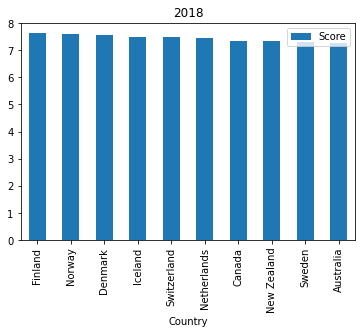

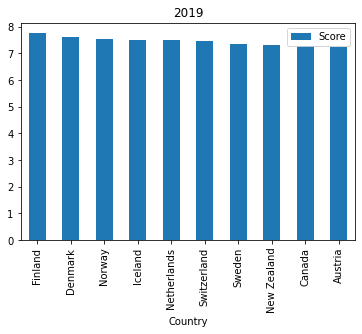

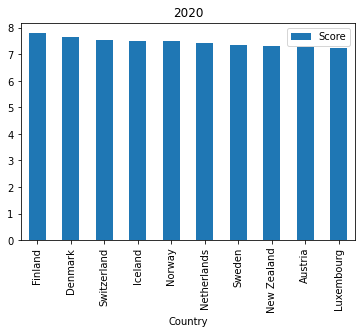

In [187]:
# I draw plots of 10 countries with the highest Happiness rate for each year to answer my first question.

year=[2018,2019,2020]
for i in range(3):
    j=df[i].sort_values(by=['Score'], ascending=False).iloc[:10]
    j[['Score']].plot(kind="bar", title=year[i])


**Answer to the question 2:**

it looks like the score is quite stable over 3 years (looking at constant, a little bit growing mean and slightly falling standard deviation) and even growing a little bit (looking at slightly growing mean, 25%, 75% and max values).

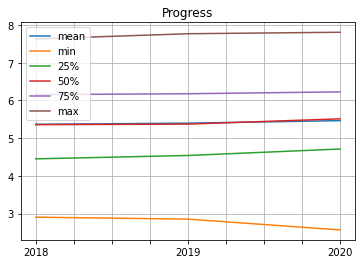

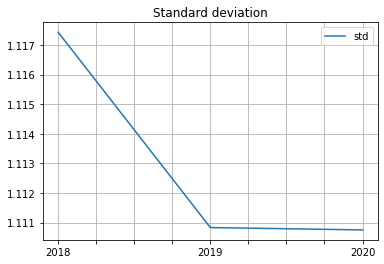

In [188]:
# Now I would like to look at the development of Happiness score over 3 years. Did people got more happy over 3 years?
# Or may be latest corona situation in 2020 made them less happy?

desc=pd.DataFrame({'2018': pd.Series(df[0]['Score'].describe(), index=df[0][['Score']].describe().index),
                   '2019': +pd.Series(df[1]['Score'].describe(), index=df[1][['Score']].describe().index),
                  '2020': +pd.Series(df[2]['Score'].describe(), index=df[2][['Score']].describe().index)})
desc.T.iloc[:, [1,3,4, 5, 6, 7]].plot(kind="line", title='Progress', grid=True);
desc.T.iloc[:, [2]].plot(kind="line", title='Standard deviation', grid=True);

**Answer to question 3:**

*From the results of the correlation I can see the sequence of the main factors that happiness depends on:*

1) the highest correlation it has with GDP per capita, Social support and Healthy life expectancy which stays stable on the first place for 3 years \
2) what is also interesting to mention is that this three variables are also have high correlation to each other: countries with higher GDP provide also higher social support and as a result probably people have higher healthy life expectancy.\
3) the third thing worth to mention is that social support correlation with GDP per capita and Healthy life expectancy is constantly growing from 2018 to 2020. May be corona presented itself and made people more sensitive to their health and to the presence of social support?\
4) Things like Freedom to make life choises and Generosity seem to have much less influence on Happiness of people, based on our datasets.

In the next steps I would like to check how good can these factors predict Happiness.



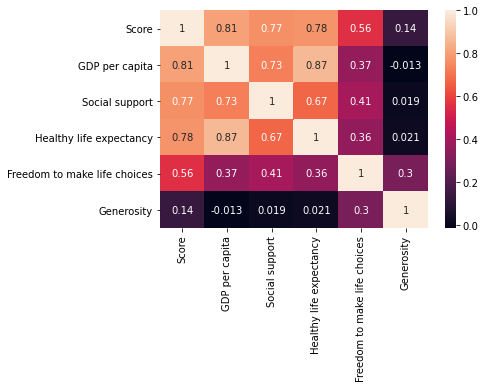

In [189]:
# I draw a correlation map for all the values in the dataset to see what do happiness score mostly depends on:

sns.heatmap(df[0][['Score', 'GDP per capita', 'Social support',
                        'Healthy life expectancy','Freedom to make life choices', 'Generosity']].corr(), annot=True);


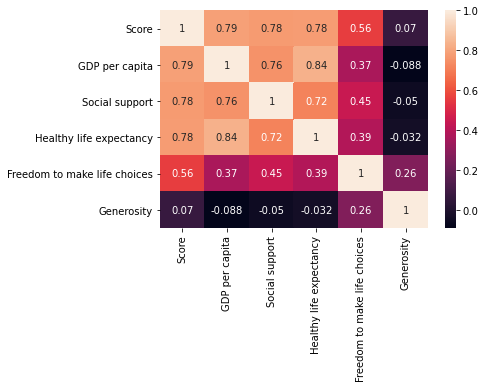

In [190]:
sns.heatmap(df[1][['Score', 'GDP per capita', 'Social support',
                        'Healthy life expectancy','Freedom to make life choices', 'Generosity']].corr(), annot=True);


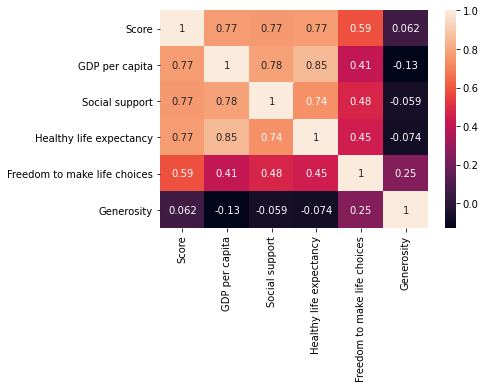

In [191]:
sns.heatmap(df[2][['Score', 'GDP per capita', 'Social support',
                        'Healthy life expectancy','Freedom to make life choices', 'Generosity']].corr(), annot=True);


In [192]:
# In this part I look how good can three main factors together (with high correlation with Score) and one by one
# explain Happiness rate.

exs=['GDP per capita','Social support','Healthy life expectancy']
for i in range(3):
    print(("Explaining Happiness in {} by tree factors: " + 
           str(modelling(df[i][['GDP per capita','Social support','Healthy life expectancy']], df[i]['Score']))).format(year[i]))
    
for j in range(3):
    print("\n")
    for i in range(3):
        print(("Explaining Happines in {} by {}: " + str(modelling(df[i][[exs[j]]], df[i]['Score'])))
          .format(year[i], exs[j]))

Explaining Happiness in 2018 by tree factors: 0.7570601107838264
Explaining Happiness in 2019 by tree factors: 0.726575960969216
Explaining Happiness in 2020 by tree factors: 0.7002248079396018


Explaining Happines in 2018 by GDP per capita: 0.6302023041778084
Explaining Happines in 2019 by GDP per capita: 0.624323951148996
Explaining Happines in 2020 by GDP per capita: 0.6825214915898445


Explaining Happines in 2018 by Social support: 0.5849761274348386
Explaining Happines in 2019 by Social support: 0.48713094740994
Explaining Happines in 2020 by Social support: 0.6836707265187287


Explaining Happines in 2018 by Healthy life expectancy: 0.6451222468961614
Explaining Happines in 2019 by Healthy life expectancy: 0.6549307732153276
Explaining Happines in 2020 by Healthy life expectancy: 0.5661834039434861


Looking at the results we can conclude that all the factors can explain Happiness score quite good, as all of the r2 values are quite high over all the 3 years.

In [193]:
#Now I would like to check it I would use all the factors, if it could explain the Score significantly better?

exs=df[1].drop('Score', axis=1).columns

for i in range(3):
    print(("Explaining Happiness in {} by tree factors: " + 
           str(modelling(df[i][list(exs)], df[i]['Score']))).format(year[i]))
    
for j in range(len(exs)):
    print("\n")
    for i in range(3):
        print(("Explaining Happines in {} by {}: " + str(modelling(df[i][[exs[j]]], df[i]['Score'])))
          .format(year[i], exs[j]))

Explaining Happiness in 2018 by tree factors: 0.7918052778744269
Explaining Happiness in 2019 by tree factors: 0.7749181770096631
Explaining Happiness in 2020 by tree factors: 0.6792093043224678


Explaining Happines in 2018 by GDP per capita: 0.6302023041778084
Explaining Happines in 2019 by GDP per capita: 0.624323951148996
Explaining Happines in 2020 by GDP per capita: 0.6825214915898445


Explaining Happines in 2018 by Social support: 0.5849761274348386
Explaining Happines in 2019 by Social support: 0.48713094740994
Explaining Happines in 2020 by Social support: 0.6836707265187287


Explaining Happines in 2018 by Healthy life expectancy: 0.6451222468961614
Explaining Happines in 2019 by Healthy life expectancy: 0.6549307732153276
Explaining Happines in 2020 by Healthy life expectancy: 0.5661834039434861


Explaining Happines in 2018 by Freedom to make life choices: 0.028455683613530014
Explaining Happines in 2019 by Freedom to make life choices: 0.2565671171697609
Explaining Happin

Looking at the rest factors, we can see, as expected that they do not contribute significantly to the explanation of the Happiness rate.

**Answer to question 4:**

Corona doesnt have much influence on the explanation of Happiness, as it has quite low value of r2. Looking at the corelation indeces I could conclude, that there are a little bit more corona cases in countries with higher GDP per capita values and probably that is why it has higher correlation with Happiness score, as Happiness score and GDP per capita have high correlation between each other.
So the answer is: no, corona doesnt have significant influence on the Happiness score.

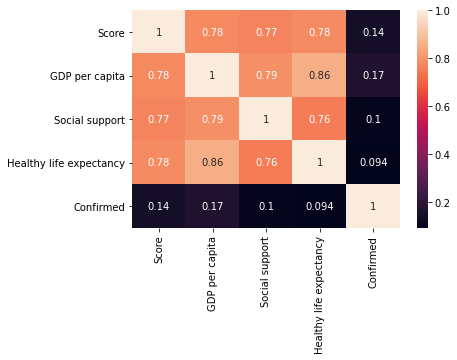

In [194]:
# Now I would like to look at the correlation map, now with corona cases included.

sns.heatmap(newdf2020[['Score', 'GDP per capita', 'Social support','Healthy life expectancy','Confirmed']].corr(), annot=True); 

In [195]:
print(("Explaining Happines in 2020 by 'Confirmed': " + str(modelling(newdf2020[['Confirmed']],
                                                                      newdf2020['Score']))))

Explaining Happines in 2020 by 'Confirmed': 0.02836177265176565


**CRISP-DM 6. Deploy**

I do this part by means on creating a post on Medium and upload my code with explanations on Github.